import requests to install tesseract

In [1]:
import requests

In [2]:
r = requests.get('https://github.com/tesseract-ocr/tesseract/wiki/4.0-with-Docker')

with open('tesseract.txt', 'w') as f:
    f.write(r.text)



In [3]:
! apt-get install tesseract-ocr libtesseract-dev libmagickwand-dev

from IPython.display import HTML, clear_output
clear_output()
print("Done!")

Done!


In [4]:
! pip install pytesseract wand opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 3.2 MB/s eta 0:00:00


In [5]:
from PIL import Image
import pytesseract
import cv2
import numpy as np
from pytesseract import Output
import re

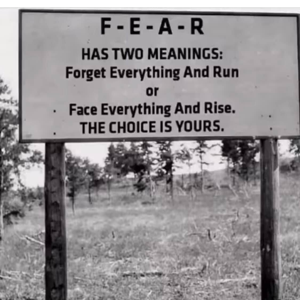

In [7]:
image = Image.open('/content/275311169_1033505353869703_9074658082525820457_n.jpg')
image = image.resize((300,300))
image.save('/content/resized_image.jpg')
image

extracting text from image

In [8]:
custom_config = r' -l eng --oem 3 --psm 6'
text = pytesseract.image_to_string(image, config=custom_config)
print(text)

F-E-A-R
HAS TWO MEANINGS:

; Forget Everything And Run
: or

i : Face Everything And Rise.

._THECHOICEISYOURS.

i See
: ~ : , ~ $
OR aan ae
a AE STAT, Soe as a OA



In [9]:
try:
  text = pytesseract.image_to_string(image, lang='eng')
  characters_to_remove = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"
  new_string = text
  for character in characters_to_remove:
    new_string = new_string.replace(character, "")
  print(new_string)
except:
  print('error')

FEAR
HAS TWO MEANINGS
Forget Everything And Run
or

 Face Everything And Rise
THE CHOICE IS YOURS

 



Now We will perform opencv operations to get text from complex images

In [10]:
image = cv2.imread('resized_image.jpg')

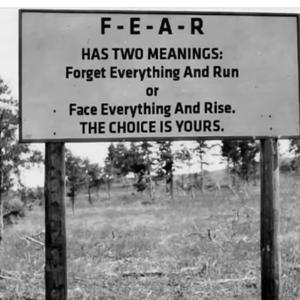

In [11]:
# get grayscale image
def get_grayscale(image):
  return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = get_grayscale(image)
Image.fromarray(gray)

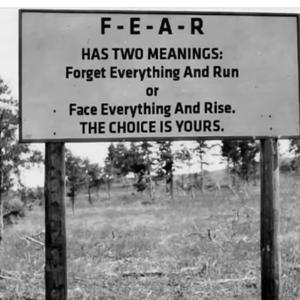

In [12]:
# noise removal
def remove_noise(image):
  return cv2.medianBlur(image, 5)
noise = remove_noise(gray)
Image.fromarray(gray)

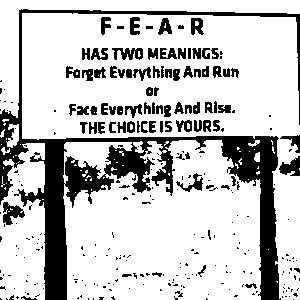

In [13]:
# thresholding
def thresholding(image):
  return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
thresh = thresholding(gray)
Image.fromarray(thresh)

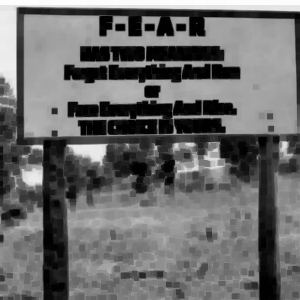

In [14]:
# erosion
def erode(image):
  kernel = np.ones((5,5), np.uint8)
  return cv2.erode(image, kernel, iterations=1)
erode = erode(gray)
Image.fromarray(erode)

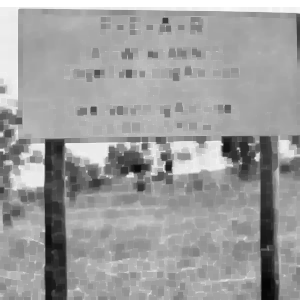

In [15]:
# morphology
def morphology(image):
  kernel = np.ones((5,5), np.uint8)
  return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)
morph = morphology(gray)
Image.fromarray(morph)

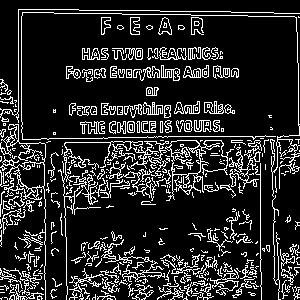

In [16]:
#canny edge detection
def canny(image):
  return cv2.Canny(image, 100, 200)
canny = canny(gray)
Image.fromarray(canny)

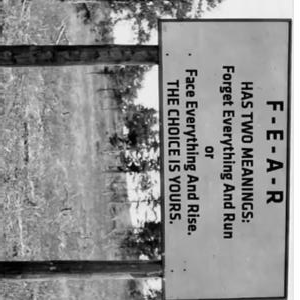

In [17]:
#skew correction
def deskew(image):
  coords = np.column_stack(np.where(image > 0))
  angle = cv2.minAreaRect(coords)[-1]
  if angle < -45:
    angle = -(90 + angle)
  else:
    angle = -angle
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  M = cv2.getRotationMatrix2D(center, angle, 1.0)
  rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
  return rotated
rotated = deskew(gray)
Image.fromarray(rotated)

In [18]:
#template matching
def match_template(image, template):
  return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)
match = match_template(gray, gray)
match

array([[1.]], dtype=float32)

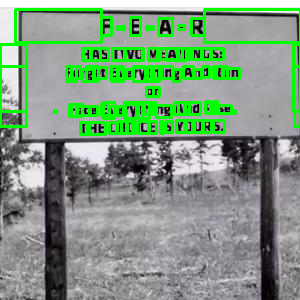

In [20]:
# drawing rectangle around text
img = cv2.imread('resized_image.jpg')
h, w, c = img.shape
boxes = pytesseract.image_to_boxes(img)
for b in boxes.splitlines():
  b = b.split(' ')
  img = cv2.rectangle(img, (int(b[1]), h - int(b[2])), (int(b[3]), h - int(b[4])), (0, 255, 0), 2)
Image.fromarray(img)

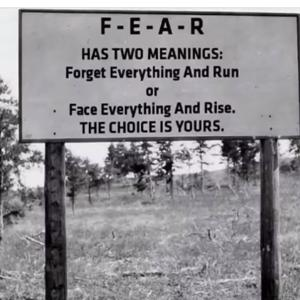

In [21]:
# Drawing pattern on specific or word
img = cv2.imread('resized_image.jpg')
d = pytesseract.image_to_data(img, output_type=Output.DICT)
keys = list(d.keys())

date_pattern = 'artificially'

n_boxes = len(d['text'])

for i in range(n_boxes):
  if float(d['conf'][i]) > 60:
    if re.match(date_pattern, d['text'][i]):
      (x, y, w, h) = (d['left'][i], d['top'][i], d['width'][i], d['height'][i])
      img = cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)

Image.fromarray(img)